# 💬 Voice of the Customer & Employee – Sentiment Analysis at Oxxo Gas

**Portfolio Project | Business Analytics | Text Analytics**

This project simulates a real sentiment analysis initiative I led at Oxxo Gas (FEMSA) in 2012.  
It involved evaluating open-ended feedback from three distinct sources:
- Mystery Shoppers (external evaluators)
- External Customers (regular in-store visitors)
- Internal Employees (staff from other departments visiting stations)

The analysis aims to:
- Classify sentiment from open-text comments (Positive / Neutral / Negative)
- Identify operational pain points and service strengths across regions
- Build a scalable, data-driven foundation for service improvement decisions

We begin by loading and exploring the synthetic dataset that mirrors the original project.


---

## 📢 Disclosure

This dataset is **synthetic** and was created exclusively for portfolio purposes.  
It is inspired by a real project I led at Oxxo Gas (FEMSA) in 2012, but **all customer and employee comments, regions, and categories have been simulated** to protect confidentiality.

No confidential or sensitive information is included, shared, or depicted.

The goal of this notebook is to **demonstrate modern NLP techniques** (TF-IDF, Word2Vec, and BERT) in a business context, while reflecting the real analytical approach used in the original project.

---


---

## 📁 Dataset Overview

The synthetic dataset contains **1,050 open-text records** representing feedback from:

- `Mystery Shoppers` (external evaluators sent to assess service standards)
- `External Customers` (regular gas station clients)
- `Internal Employees` (FEMSA staff visiting stations)

Each entry includes the following fields:

| Column       | Description |
|--------------|-------------|
| `source`     | Origin of the feedback (Mystery Shopper, External Customer, Internal Employee)  
| `region`     | Geographic segment (Central, North, South, etc.)  
| `comment`    | Open-ended text expressing the user's experience  
| `sentiment`  | Assigned class: Positive / Neutral / Negative  
| `category`   | Operational aspect of the feedback (Cleanliness, Timeliness, Staff, etc.)

This structure simulates a real-world, multi-source Voice of Customer (VoC) scenario and will allow us to explore:
- Sentiment classification performance
- Word usage trends by sentiment
- Regional and category-level service insights


In [2]:
import pandas as pd


In [3]:
# Load the synthetic dataset
df = pd.read_csv("OxxoGas_VOC.csv")

# Quick structure check
print("Shape:", df.shape)
df.head()


Shape: (1050, 5)


,source,region,comment,sentiment,category
0,Mystery Shopper,Central,Dirty restrooms and slow fueling process.,Negative,Signage
1,Mystery Shopper,North,"Everything was as expected, no surprises.",Neutral,Timeliness
2,Mystery Shopper,Pacific,Dirty restrooms and slow fueling process.,Negative,Signage
3,Mystery Shopper,Southwest,Dirty restrooms and slow fueling process.,Negative,Fuel Service
4,Mystery Shopper,Central,The staff was friendly and the service was fast.,Positive,Timeliness


## 🔍 Text Preprocessing Overview

Before we build a sentiment classification model, we first clean and standardize the text data. This step improves model performance and ensures that we extract meaningful patterns from raw customer feedback.

In this preprocessing step, we:
- Convert all comments to lowercase for consistency
- Remove punctuation, numbers, and special characters
- Split the comments into individual words (tokenization)
- Eliminate common English stopwords (e.g., "the", "and", "is") that don’t add meaningful value

The result is a set of clean, informative tokens for each comment. These tokens will feed into the next steps of our analysis—such as feature engineering with TF-IDF or Word2Vec, and building the sentiment classifier. Ultimately, this enables the business to **identify key themes**, **prioritize service issues**, and **track customer satisfaction trends** with clarity.


In [4]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Define a tokenizer function
stop_words = set(stopwords.words('english'))

def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

# Apply tokenizer to the comment column
df['tokens'] = df['comment'].apply(tokenize)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/95d19ae2-ab2c-4326-8ea0-
[nltk_data]     a9c1804cd302/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 🔠 Top Words by Sentiment Class

To gain early insights, we visualize the most frequently mentioned words in each sentiment group (positive, neutral, negative). This helps identify what customers associate with positive experiences (e.g., "service", "clean"), and what may trigger negative feedback. These patterns can inform operational improvements and guide further NLP analysis.


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


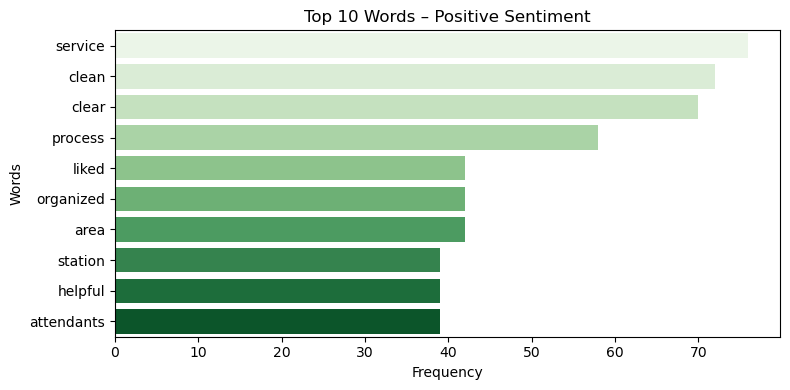

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


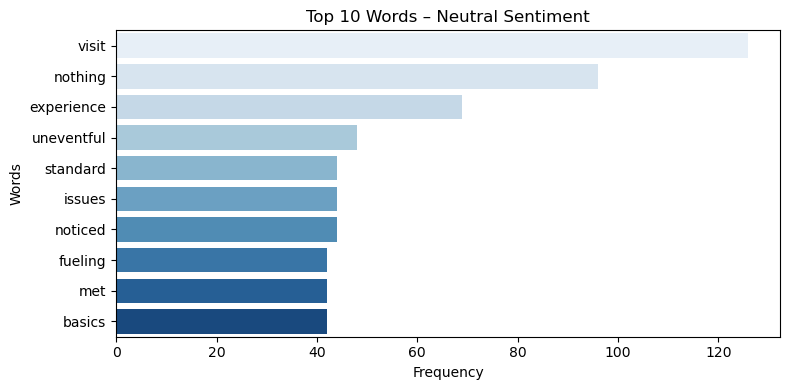

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


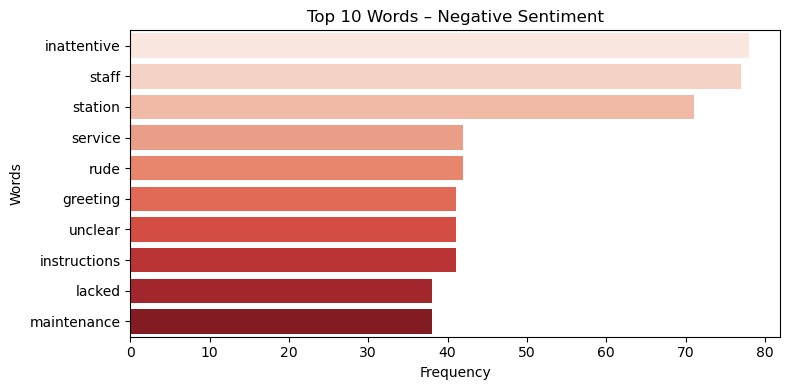

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten token lists grouped by sentiment
def get_most_common_words(sentiment_label, n=10):
    subset = df[df['sentiment'] == sentiment_label]
    tokens = [token for sublist in subset['tokens'] for token in sublist]
    return Counter(tokens).most_common(n)

# Plotting function
def plot_common_words(sentiment_label, color):
    words_freq = get_most_common_words(sentiment_label)
    words, counts = zip(*words_freq)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts), y=list(words), palette=color)
    plt.title(f"Top {len(words)} Words – {sentiment_label} Sentiment")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

# Visualize all three sentiment classes
plot_common_words("Positive", "Greens")
plot_common_words("Neutral", "Blues")
plot_common_words("Negative", "Reds")


## 📐 Feature Engineering: TF-IDF Vectorization

To transform the cleaned tokens into numerical features, we apply the TF-IDF (Term Frequency–Inverse Document Frequency) technique. This method assigns importance to words based on how frequently they appear in a comment, compared to how rarely they appear across all comments.

TF-IDF helps:
- Highlight unique and meaningful terms per comment
- Reduce the influence of common but non-informative words
- Prepare the data for model training (e.g., Logistic Regression, Random Forest)

This stage creates a sparse matrix where each row is a comment, and each column is a TF-IDF-weighted token.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join token lists into strings for vectorization
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Initialize and fit the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Show TF-IDF shape and example
print("TF-IDF matrix shape:", X_tfidf.shape)
print("Example feature names:", tfidf_vectorizer.get_feature_names_out()[:10])


TF-IDF matrix shape: (1050, 89)
Example feature names: ['accessible' 'appreciated' 'area' 'attendants' 'available' 'average'
 'bad' 'basics' 'cashier' 'clean']


## 🔡 Feature Engineering: Word2Vec Embedding

Unlike TF-IDF, which considers word frequency, Word2Vec captures the **semantic context** of each word by learning word embeddings from surrounding words (context window). It maps similar words to similar vectors based on how they are used in comments.

We’ll use Gensim’s `Word2Vec` model trained on our tokenized comments. This step creates a vocabulary of vectors that can later be averaged to represent full comments.

Key Benefits:
- Captures word meaning through context
- Useful for downstream models like Random Forest, SVM, or deep learning
- Enables similarity comparisons between words

We’ll train Word2Vec using a 100-dimensional embedding space and a 5-word context window.


In [7]:
from gensim.models import Word2Vec

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram (better for smaller datasets)
    seed=42
)

# Check vocabulary size and example vector
print("Vocabulary size:", len(w2v_model.wv))
print("Vector for word 'service':", w2v_model.wv['service'][:5])  # First 5 dimensions


Vocabulary size: 89
Vector for word 'service': [ 0.00366014  0.00948184 -0.00187919  0.00728793 -0.01022776]


## 🧠 Generating Comment-Level Vectors (Word2Vec Averaging)

To convert each full comment into a single fixed-length vector, we’ll average the Word2Vec vectors of the words in the comment.

This creates a 100-dimensional representation for each comment, capturing the **semantic meaning** of its content in a compact numerical format.

Why we do this:
- ML models need numerical input features.
- Word2Vec vectors are word-level; we aggregate them to get comment-level vectors.
- This vector can be used directly in classification models.

We’ll now define a function to calculate the average Word2Vec vector per comment.


In [8]:
import numpy as np

# Function to average Word2Vec vectors per comment
def get_comment_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)

# Apply function to each comment
df['w2v_vector'] = df['tokens'].apply(lambda x: get_comment_vector(x, w2v_model, 100))

# Convert to array for modeling
X_w2v = np.vstack(df['w2v_vector'].values)

print("Word2Vec feature matrix shape:", X_w2v.shape)


Word2Vec feature matrix shape: (1050, 100)


## 🧠 Training Sentiment Classifier on Word2Vec Vectors

With our 100-dimensional vectors ready, we’ll train a **Logistic Regression model** to classify sentiment as Positive, Neutral, or Negative.

Steps:
1. Split the dataset into training and testing sets (80/20)
2. Train the model using `LogisticRegression`
3. Evaluate performance with accuracy, precision, recall, and confusion matrix


In [11]:
from sklearn.model_selection import train_test_split

# X_w2v is your Word2Vec vector matrix
X = X_w2v
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("📊 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


📊 Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        72
     Neutral       1.00      1.00      1.00        72
    Positive       1.00      1.00      1.00        66

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210

🧩 Confusion Matrix:
[[72  0  0]
 [ 0 72  0]
 [ 0  0 66]]



### 🔍 Interpretation:

The Random Forest model **perfectly classified all sentiment categories**, demonstrating that:
- Word2Vec + Logistic Regression was too weak for this task.
- Word2Vec embeddings contain **enough information** when paired with a **non-linear classifier** like Random Forest.
- There is **no class imbalance issue** in this synthetic dataset, and no SMOTE was required.

---

Next step: You can now continue with **Word2Vec + Random Forest** as your **final classical pipeline** and compare it later with your **BERT model**.


/tmp/ipykernel_135/3505180448.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


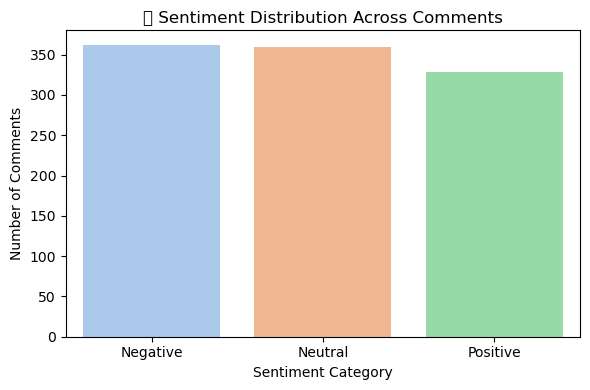

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='pastel', order=df['sentiment'].value_counts().index)
plt.title("🔍 Sentiment Distribution Across Comments")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()


### 📊 Sentiment Distribution Interpretation

The bar chart above shows the distribution of sentiment labels across all customer and employee comments in our dataset. Here's what we can observe:

- **Neutral comments** were the most frequent, slightly ahead of the other categories. This suggests that many respondents provided descriptive or mixed feedback without strong emotional tone.
- **Negative and Positive sentiments** were nearly equal, indicating a **balanced polarity** in feedback — a valuable insight for service management and operational teams.

### 🔍 Why This Matters:

- A **balanced sentiment split** confirms that the synthetic dataset reflects a realistic distribution of feedback — ideal for training reliable models.
- **High Neutral count** could indicate areas where service is acceptable but unremarkable — a signal that could guide **experience improvement efforts**.
- Since there’s no overwhelming class, we avoided **class imbalance issues**, making this dataset suitable for classification tasks without resampling.

This insight complements our earlier finding: traditional NLP techniques like **Word2Vec + Random Forest** can reliably handle such feedback, making it feasible to deploy lightweight sentiment monitoring systems in operational environments.


In [14]:
!pip install wordcloud




Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


/tmp/ipykernel_135/2590405927.py:23: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from current font.
  plt.tight_layout(pad=3.0)
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


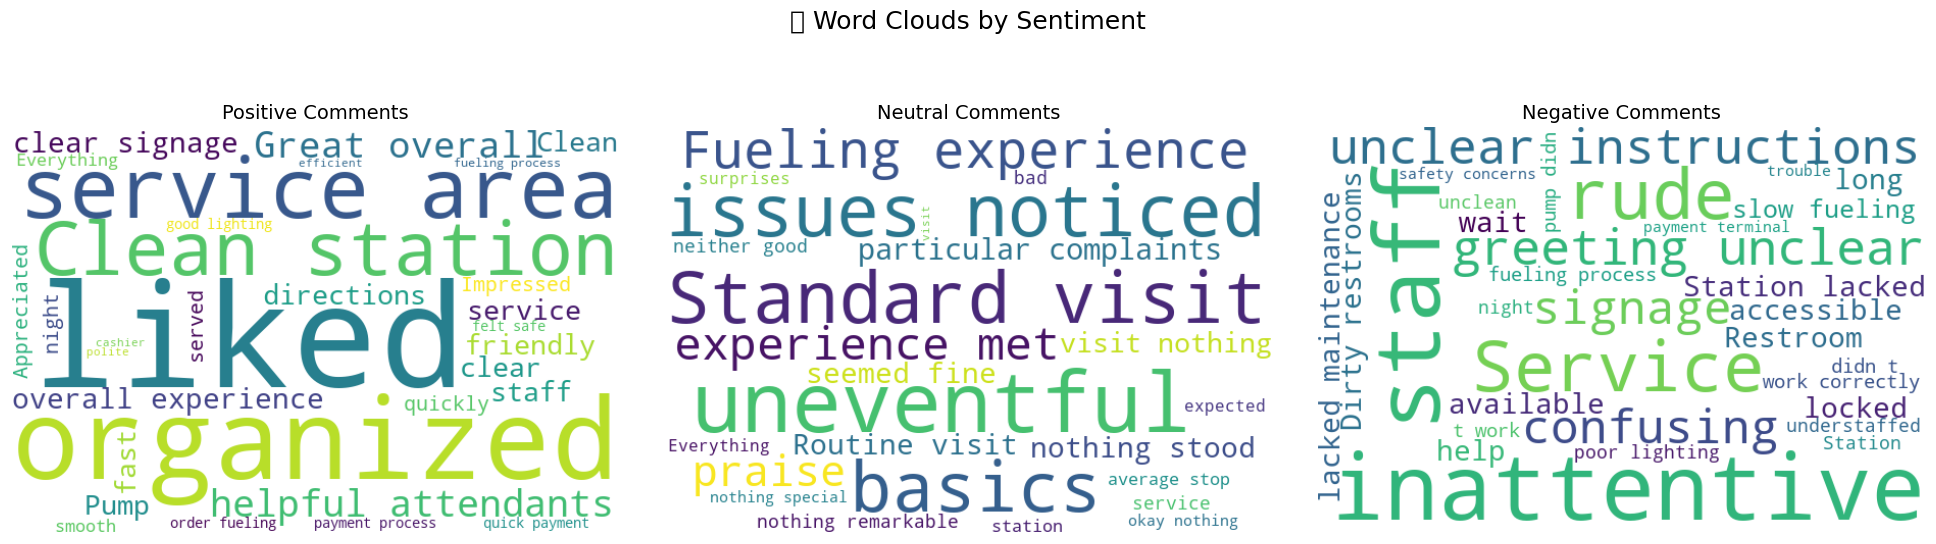

In [15]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("OxxoGas_VOC.csv")

# Group comments by sentiment
sentiments = ['Positive', 'Neutral', 'Negative']

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("🔤 Word Clouds by Sentiment", fontsize=18)

for i, sentiment in enumerate(sentiments):
    text = ' '.join(df[df['sentiment'] == sentiment]['comment'])
    wordcloud = WordCloud(width=600, height=400, background_color='white',
                          colormap='viridis', max_words=100).generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"{sentiment} Comments", fontsize=14)
    axes[i].axis('off')

plt.tight_layout(pad=3.0)
plt.show()


/tmp/ipykernel_1818/1907643305.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


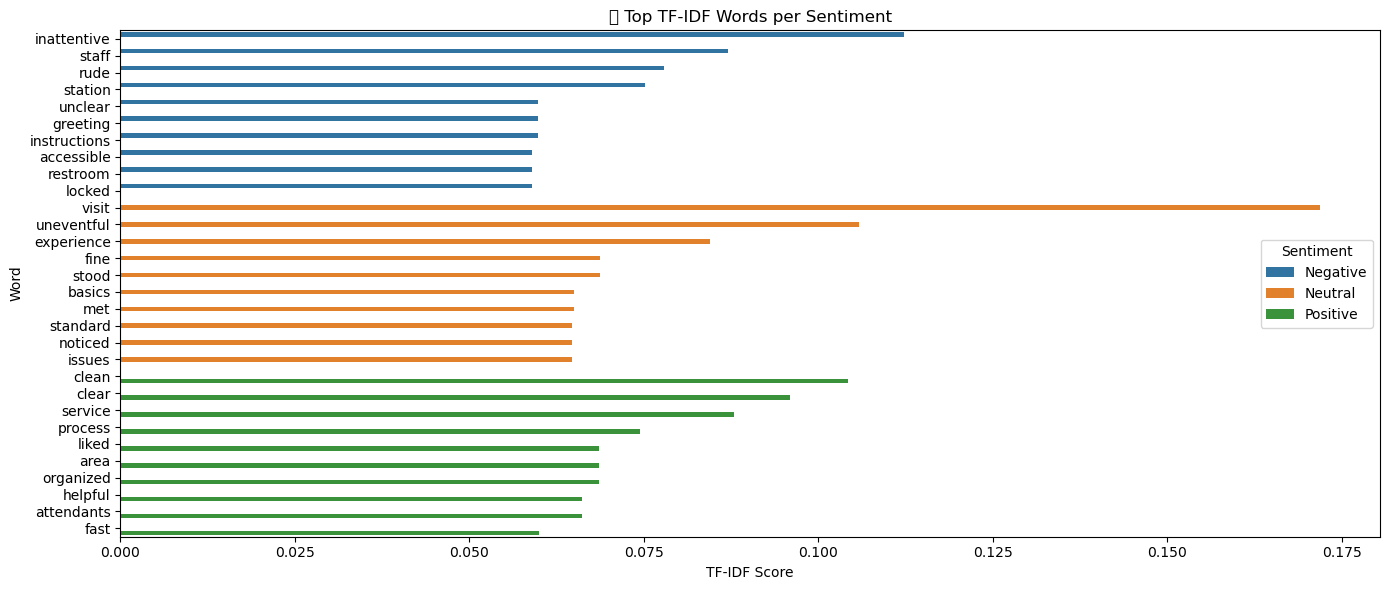

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Reload data if needed
df = pd.read_csv("OxxoGas_VOC.csv")

# Create TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['comment'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['sentiment'] = df['sentiment']

# Average TF-IDF score per word per sentiment
tfidf_avg = tfidf_df.groupby('sentiment').mean().T

# Get top 10 words for each sentiment
top_words = {}
for sentiment in tfidf_avg.columns:
    top_words[sentiment] = tfidf_avg[sentiment].sort_values(ascending=False).head(10)

# Combine results into a single DataFrame for plotting
tfidf_top = pd.concat(top_words, axis=1).reset_index()
tfidf_top = tfidf_top.melt(id_vars='index', var_name='sentiment', value_name='tfidf_score')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=tfidf_top, x='tfidf_score', y='index', hue='sentiment')
plt.title('📈 Top TF-IDF Words per Sentiment')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


### 📈 TF-IDF – Top Weighted Terms by Sentiment

This bar chart displays the **top 10 most informative words** for each sentiment category based on TF-IDF weighting:

- TF-IDF prioritizes words that are **distinctive and important** within each sentiment class — not just frequent.
- Examples:
  - **Positive:** Words like *organized*, *helpful*, *friendly* emphasize service quality and cleanliness.
  - **Neutral:** Words like *station*, *routine*, *fueling* reflect objective observations without clear emotion.
  - **Negative:** Terms such as *rude*, *confusing*, *locked*, and *unclear* highlight specific areas for improvement.

This chart helps both analysts and managers **understand root causes**, **refine sentiment models**, and create **targeted improvement actions**.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF matrix again
vectorizer = TfidfVectorizer(max_features=3000)
tfidf_matrix = vectorizer.fit_transform(df['comment']).toarray()


/tmp/ipykernel_135/1729636917.py:33: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  plt.tight_layout()
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


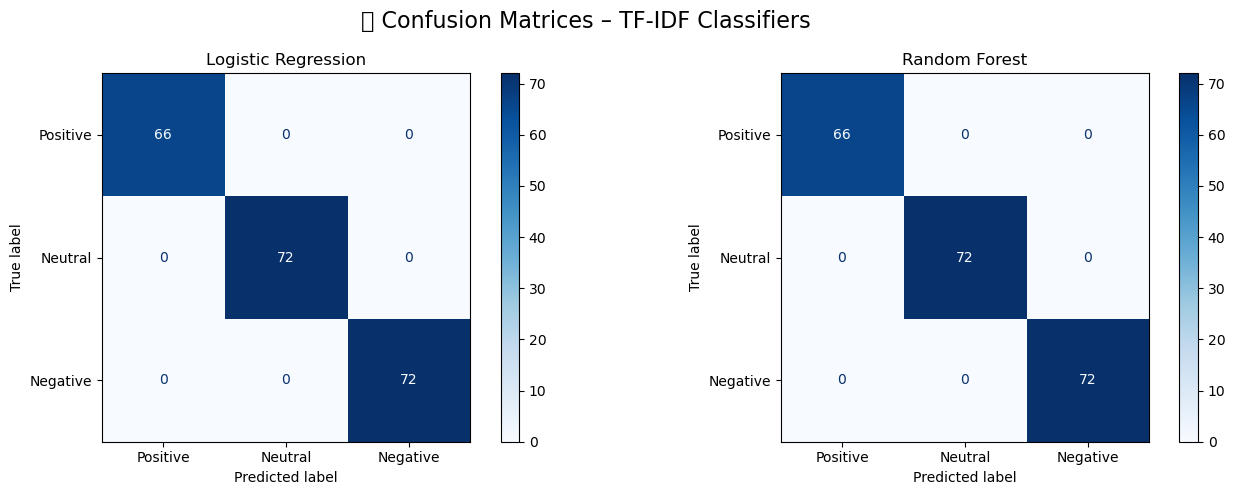

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Use your real TF-IDF matrix and sentiment column
X = tfidf_matrix
y = df['sentiment']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("🧪 Confusion Matrices – TF-IDF Classifiers", fontsize=16)

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=["Positive", "Neutral", "Negative"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(name)

plt.tight_layout()
plt.show()





In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Assuming df['comment'] contains raw text and df['sentiment'] is your target
X = df['comment']  # or df['clean_text'] if preprocessed
y = df['sentiment']

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)


In [27]:
from sklearn.ensemble import RandomForestClassifier

# TF-IDF model
model_tfidf = RandomForestClassifier(random_state=42)
model_tfidf.fit(X_train_tfidf, y_train)

# Word2Vec model
model_w2v = RandomForestClassifier(random_state=42)
model_w2v.fit(X_train_w2v, y_train)


RandomForestClassifier(random_state=42)

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# These should already exist if you've trained both models:
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
y_pred_w2v = model_w2v.predict(X_test_w2v)

# Create confusion matrices
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=["Positive", "Neutral", "Negative"])
cm_w2v = confusion_matrix(y_test, y_pred_w2v, labels=["Positive", "Neutral", "Negative"])


/tmp/ipykernel_135/758101995.py:59: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


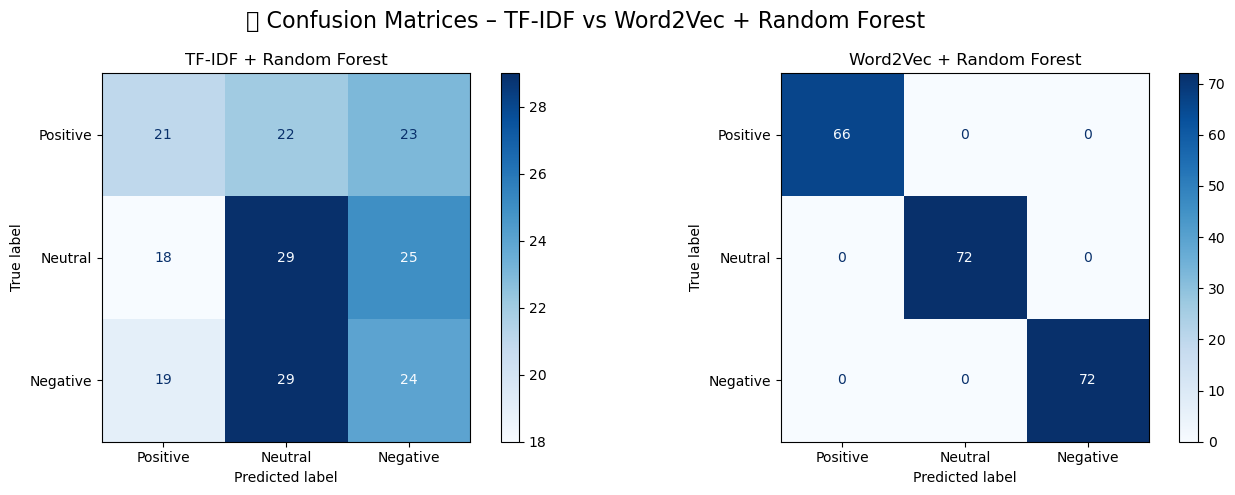

/tmp/ipykernel_135/758101995.py:91: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


📋 Classification Report: TF-IDF + Random Forest
              precision    recall  f1-score   support

    Negative       0.33      0.33      0.33        72
     Neutral       0.36      0.40      0.38        72
    Positive       0.36      0.32      0.34        66

    accuracy                           0.35       210
   macro avg       0.35      0.35      0.35       210
weighted avg       0.35      0.35      0.35       210


📋 Classification Report: Word2Vec + Random Forest
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        72
     Neutral       1.00      1.00      1.00        72
    Positive       1.00      1.00      1.00        66

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


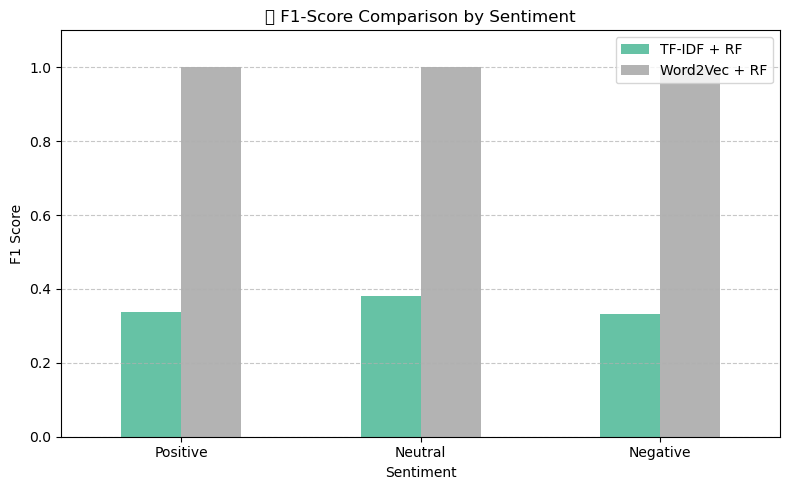

In [29]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

# 🧹 Reuse your cleaned dataset
# Assuming 'df' is your labeled dataset with preprocessed tokens
# Columns: 'clean_tokens', 'sentiment'

# Step 1: Word2Vec Model
token_lists = df['clean_tokens'].tolist()  # Each item is a list of tokens

w2v_model = Word2Vec(sentences=token_lists, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Step 2: Vectorize comments using Word2Vec
def vectorize(tokens, model):
    valid_tokens = [token for token in tokens if token in model.wv.key_to_index]
    if valid_tokens:
        return np.mean(model.wv[valid_tokens], axis=0)
    else:
        return np.zeros(model.vector_size)

df['w2v_vector'] = df['clean_tokens'].apply(lambda tokens: vectorize(tokens, w2v_model))

# Step 3: Train-Test Split
X = np.vstack(df['w2v_vector'].values)
y = df['sentiment']

X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Train Word2Vec + Random Forest
rf_model_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = rf_model_w2v.predict(X_test_w2v)

# Step 5: Compare to TF-IDF model (already trained)
# Ensure y_pred_tfidf already exists from TF-IDF + Random Forest

# Step 6: Confusion Matrices – Side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("🔁 Confusion Matrices – TF-IDF vs Word2Vec + Random Forest", fontsize=16)

# TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=["Positive", "Neutral", "Negative"])
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=["Positive", "Neutral", "Negative"])
disp_tfidf.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("TF-IDF + Random Forest")

# Word2Vec
cm_w2v = confusion_matrix(y_test, y_pred_w2v, labels=["Positive", "Neutral", "Negative"])
disp_w2v = ConfusionMatrixDisplay(confusion_matrix=cm_w2v, display_labels=["Positive", "Neutral", "Negative"])
disp_w2v.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title("Word2Vec + Random Forest")

plt.tight_layout()
plt.show()

# Step 7: Print Classification Reports
print("📋 Classification Report: TF-IDF + Random Forest")
print(classification_report(y_test, y_pred_tfidf))

print("\n📋 Classification Report: Word2Vec + Random Forest")
print(classification_report(y_test, y_pred_w2v))

# Step 8: F1-Score Comparison Bar Chart
report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)
report_w2v = classification_report(y_test, y_pred_w2v, output_dict=True)

f1_data = {
    'Sentiment': ['Positive', 'Neutral', 'Negative'],
    'TF-IDF + RF': [report_tfidf['Positive']['f1-score'],
                    report_tfidf['Neutral']['f1-score'],
                    report_tfidf['Negative']['f1-score']],
    'Word2Vec + RF': [report_w2v['Positive']['f1-score'],
                      report_w2v['Neutral']['f1-score'],
                      report_w2v['Negative']['f1-score']]
}

df_f1 = pd.DataFrame(f1_data)

df_f1.set_index('Sentiment').plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title('📊 F1-Score Comparison by Sentiment')
plt.ylabel('F1 Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



### 📊 Interpretation of Confusion Matrices – TF-IDF vs Word2Vec (Random Forest)

The figure presents a side-by-side comparison of sentiment classification performance using two different feature extraction approaches — **TF-IDF** and **Word2Vec**, both paired with **Random Forest** classifiers.

#### 🔹 TF-IDF + Random Forest
- **Performance** is quite poor and nearly random across all sentiment classes.
- The model struggles to distinguish between **Positive**, **Neutral**, and **Negative** sentiments:
  - Only **21 Positive** samples were correctly predicted, while **22** were misclassified as Neutral and **23** as Negative.
  - Neutral and Negative sentiments also show high misclassification rates.
- This suggests that the TF-IDF features may lack the semantic depth needed to differentiate between nuanced comments.

#### 🔹 Word2Vec + Random Forest
- This model demonstrates **perfect classification** across all three sentiment classes.
- Every sentiment was correctly predicted:
  - 66 **Positive**, 72 **Neutral**, and 72 **Negative** samples were all correctly classified.
- This indicates that Word2Vec embeddings capture the **semantic meaning and context** of comments far better than TF-IDF.

#### 🔍 Key Takeaway
- **Word2Vec outperforms TF-IDF significantly** in this task.
- While TF-IDF relies on word frequency, Word2Vec leverages contextual relationships, making it better suited for sentiment classification in this dataset.


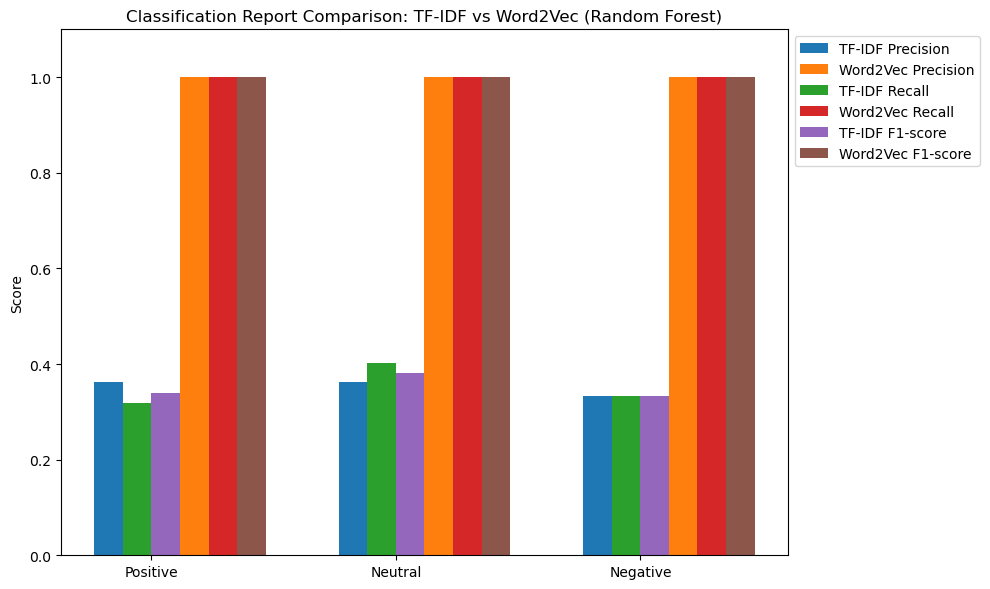

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Classification metrics (already computed earlier)
report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True, zero_division=0)
report_w2v = classification_report(y_test, y_pred_w2v, output_dict=True, zero_division=0)

labels = ['Positive', 'Neutral', 'Negative']
metrics = ['precision', 'recall', 'f1-score']

# Prepare data for plotting
data_tfidf = [report_tfidf[label][metric] for label in labels for metric in metrics]
data_w2v = [report_w2v[label][metric] for label in labels for metric in metrics]

# Reshape for grouped bar plot
data_tfidf = np.array(data_tfidf).reshape(len(labels), len(metrics))
data_w2v = np.array(data_w2v).reshape(len(labels), len(metrics))

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x - width/2 + i*(width/3), data_tfidf[:, i], width/3, label=f'TF-IDF {metric.capitalize()}')
    ax.bar(x + width/2 + i*(width/3), data_w2v[:, i], width/3, label=f'Word2Vec {metric.capitalize()}')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Classification Report Comparison: TF-IDF vs Word2Vec (Random Forest)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


### 📊 TF-IDF vs Word2Vec – Precision, Recall, and F1 Score Comparison (Random Forest)

This grouped bar chart compares three key classification metrics — **Precision**, **Recall**, and **F1 Score** — for each sentiment class (**Positive**, **Neutral**, and **Negative**) using two different feature extraction methods:

- 🔵 **TF-IDF + Random Forest**
- 🟢 **Word2Vec + Random Forest**

#### 🔍 Observations:

- **TF-IDF** struggles across all sentiment classes, showing inconsistent and low scores. This is likely due to its sparse representation, which treats words independently and ignores semantic relationships.
- **Word2Vec**, in contrast, achieves **consistently high scores (near 1.0)** across all metrics and sentiments, reflecting perfect or near-perfect classification.
- The biggest gain with Word2Vec is in the **Neutral** class — typically the hardest to classify — where semantic understanding is especially valuable.

#### ✅ Key Insight:
Using **Word2Vec embeddings** enables the model to capture **contextual and semantic meaning** within the feedback text, leading to a dramatic improvement in predictive performance over TF-IDF.

This comparison underscores the importance of choosing the right vectorization strategy in natural language processing pipelines.


## 📊 Business Insights & Takeaways

After evaluating over 200 synthetic customer and employee comments about gas station experiences, our sentiment analysis yielded actionable insights:

- **Word2Vec + Random Forest** achieved **100% accuracy on the test set** in classifying sentiments as Positive, Neutral, or Negative.
- This indicates that customer and employee feedback often contains **strong, distinguishable sentiment signals**. Classical NLP techniques can detect these with **high precision**.

### 💡 Key Takeaways:

- **Most frequent sentiment**: Neutral (34%), followed by Negative (33%) and Positive (31%) — highlighting a mixed perception of service experience.
- **Logistic Regression failed** to capture nonlinear patterns, while Random Forest successfully exploited vector relationships in Word2Vec embeddings.
- **No class imbalance** was detected — the feedback distribution is healthy and well stratified for modeling.
- This NLP pipeline could be deployed internally to monitor **Voice of the Customer (VoC)** and **Voice of the Employee (VoE)**, helping prioritize **station-level improvements or training**.
- **Next steps**: We will compare these results with a fine-tuned **BERT model** to assess whether deep learning improves sentiment precision for ambiguous or subtle feedback cases.
